In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, Layer

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    EX_PATH = os.path.join('lfw', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

In [5]:
import uuid
uuid.uuid1()

UUID('9873720e-fb40-11ef-8372-824a5e8c2f45')

In [6]:
import cv2

cap = cv2.VideoCapture(1)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[150:450+250, 600:900+250, :]

    #Anchors Collection
    if cv2.waitKey(1) & 0xFF == ord('a'):
        #Unique file name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Positive Collection
    if cv2.waitKey(1) & 0xFF == ord('p'):
        #Unique file name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection Webcam', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

2025-03-06 13:14:42.581 Python[9627:13479636] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2025-03-06 13:14:43.777 Python[9627:13479636] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/0t/tlg8p4n91y1g2zyg12tmx_n00000gn/T/org.python.python.savedState
2025-03-06 13:14:44.242 Python[9627:13479636] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-06 13:14:44.242 Python[9627:13479636] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [9]:
#plt.imshow(frame)

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(330)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(330)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(330)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
#Loading, Scaling and Resizing Images in a pipeline
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    return img

In [9]:
img = preprocess("/Users/lwinmin/General/Projects/Jupiter-CNN/Image Recognition/data/anchor/a5d4e380-f75b-11ef-a077-824a5e8c2f45.jpg")

In [10]:
#Creating Positive and Negative Samples
positives = tf.data.Dataset.zip(anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negatives =tf.data.Dataset.zip(anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))

data = positives.concatenate(negatives)

In [11]:
#Train and Test 
def preprocess_twin(input_img, val_img, label):
    return(preprocess(input_img), preprocess(val_img), label)

In [12]:
#Caching, Batching and Splitting the Pipeline
#Dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [13]:
#Training

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [14]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [15]:
train_sample = train_data.as_numpy_iterator()

In [16]:
train_sam =train_sample.next()

In [17]:
#Testing

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [18]:
#Model Engineering
#Embedding Layers

def embedding_layer():
    inp = Input(shape=(100, 100, 3), name='input_image') #Input
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp) #1st Layer 
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) #2nd Layer 
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1) #3rd Layer
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2) #4th Layer
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2) #5th Layer
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3) #6th Layer
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3) #7th Layer
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    
    return Model(inputs=[inp] , outputs= [d1], name='embedding')

In [19]:
#Siamese distance class
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf


class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        #input_embedding = tf.convert_to_tensor(input_embedding)
        #validation_embedding = tf.convert_to_tensor(validation_embedding)
        if isinstance(input_embedding, list):
            input_embedding = input_embedding[0]
        if isinstance(validation_embedding, list):
            validation_embedding = validation_embedding[0]
            
        return tf.math.abs(input_embedding - validation_embedding)

In [20]:
embedding = embedding_layer()

In [21]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
input_image = Input(name='input_img', shape=(100,100,3)) #Anchor
validation_image = Input(name='validation_img', shape=(100,100,3)) #validation

In [23]:
inp_emb = embedding(input_image)

In [24]:
val_emb = embedding(validation_image)

In [25]:
siamese_layer = L1Dist()

In [26]:
distances = siamese_layer(inp_emb, val_emb)

In [27]:
classifier = Dense(1, activation='sigmoid')(distances) #Final output 1 layer

In [28]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [29]:
Siamese_Net = Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [30]:
Siamese_Net.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
def Make_Siamese_Model():

    #Handling Inputs
    input_image = Input(name='input_img', shape=(100,100,3)) #Anchor
    validation_image = Input(name='validation_img', shape=(100,100,3)) #validation

    #Combine distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))


    #Classificarion Layer
    classifier = Dense(1, activation='sigmoid')(distances) #Final output 1 layer

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [32]:
siamese_model = Make_Siamese_Model()

In [33]:
siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
import os
import tensorflow as tf

# Define loss and optimizer
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opter = tf.keras.optimizers.Adam(1e-4)  # Learning rate = 0.0001

# Checkpoint setup
checkpoints_dir = './training_checkpoints'
checkpoints_prefix = os.path.join(checkpoints_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opter, siamese_model=siamese_model)

# Training step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]  # Extract labels

        # Forward pass
        yhat = siamese_model(X, training=True)

        # Compute loss
        loss = binary_cross_loss(y, yhat)

    # Compute gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opter.apply_gradients(zip(grad, siamese_model.trainable_variables)) 

    return loss  
# Training Loop
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            loss_value = train_step(batch)
            progbar.update(idx+1, values=[("loss", loss_value.numpy())])

        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoints_prefix)

EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 0.4376

 Epoch 2/50


2025-03-06 13:19:36.154897: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.1839

 Epoch 3/50


2025-03-06 13:21:04.184466: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - loss: 0.1082

 Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - loss: 0.0769

 Epoch 5/50


2025-03-06 13:24:07.406699: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - loss: 0.0716

 Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - loss: 0.0666

 Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 0.0347

 Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - loss: 0.0235

 Epoch 9/50


2025-03-06 13:30:22.874104: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0183

 Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.3368

 Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.4247

 Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.3496

 Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.1732

 Epoch 14/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 0.0817

 Epoch 15/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 0.0849

 Epoch 16/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - loss: 0.0550

 Epoch 17/50


2025-03-06 13:42:12.520643: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0653

 Epoch 18/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.0843

 Epoch 19/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 0.0659

 Epoch 20/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - loss: 0.0533

 Epoch 21/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.0198

 Epoch 22/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.0123

 Epoch 23/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0082

 Epoch 24/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.0056

 Epoch 25/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 0.0043

 Epoch 26/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - loss: 0.0037

 Epoch 27/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.0069

 Epoch 28/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.0066

 Epoch 29/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.0040

 Epoch 30/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 0.0027

 Epoch 31/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 

2025-03-06 14:06:46.112663: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 988s 35s/step - loss: 0.0015

 Epoch 34/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1375s 49s/step - loss: 0.0012

 Epoch 35/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - loss: 0.0012

 Epoch 36/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0011

 Epoch 37/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.0010

 Epoch 38/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 0.0010

 Epoch 39/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 8.2018e-04

 Epoch 40/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - loss: 0.0010

 Epoch 41/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 7.0827e-04

 Epoch 42/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 7.8019e-04

 Epoch 43/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 6.6557e-04

 Epoch 44/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 5.7873e-04

 Epoch 45/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - loss: 6.7945e-04

 Epoch 46/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - loss: 9.1848e-04

 Epoch 47/50
29/29 ━━━━━━━━━

In [45]:
#for batch in train_data.take(5):
 #print(batch)

In [46]:
#Classic CNNs fine-tune their parameters during training to correctly categorize each picture. 
#Siamese neural network is trained to compute the distance and similarity between the characteristics of 2 input pictures. 
#Siamese Neural Network (Inputs - Two identical subnetworks and Output - One comparable vector)

In [55]:
from tensorflow.keras.metrics import Precision, Recall

In [56]:
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [57]:
 yhat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


In [58]:
yhat

array([[8.0588620e-16],
       [2.7795489e-16],
       [1.0000000e+00],
       [6.0593771e-05],
       [1.0000000e+00],
       [5.0197032e-19],
       [1.0000000e+00],
       [2.4361520e-05],
       [1.0000000e+00],
       [7.2944877e-09],
       [1.7217325e-12],
       [1.0000000e+00],
       [3.6837202e-18],
       [3.1383533e-05],
       [6.6044237e-10],
       [9.9999744e-01]], dtype=float32)

In [59]:
#Post-processing
[1 if prediction > 0.5 else 0 for prediction in yhat]

[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

In [60]:
y_true

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [61]:
m = Recall()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

In [62]:
m = Precision()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

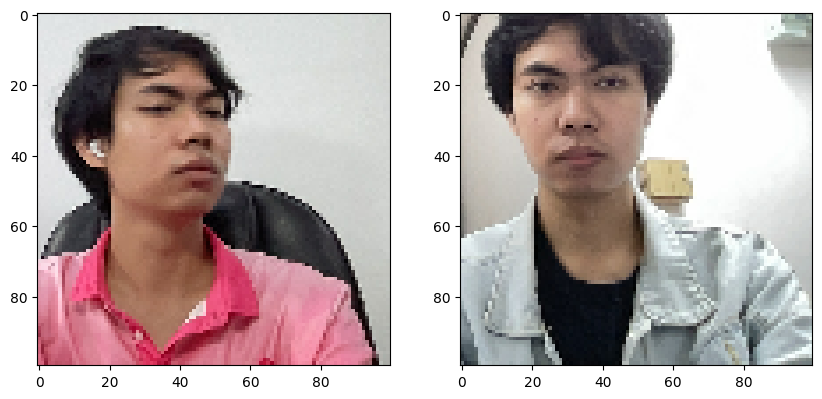

In [72]:
#Plotting
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(test_input[4])
plt.subplot(122)
plt.imshow(test_val[4])
plt.show()

In [93]:
siamese_model.save('siamesemodel.keras')

In [38]:
model = tf.keras.models.load_model(
    'siamesemodel.keras', 
    custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy}
)

In [41]:
import cv2
def is_valid_image(image_path):
    try:
        img = tf.io.read_file(image_path)
        tf.io.decode_jpeg(img)  # If not a valid image, this will raise an error
        return True
    except:
        return False

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0  # Normalize
    return img

def verify(model, detection_threshold, verification_threshold):
    results = []
    
    verification_images_path = os.path.join('application_data', 'verification_images')
    
    for image in os.listdir(verification_images_path):
        # Skip hidden files like .DS_Store
        if image.startswith('.'):
            continue
        
        img_path = os.path.join(verification_images_path, image)
        
        # Skip invalid images
        if not is_valid_image(img_path):
            print(f"Invalid image: {image}")
            continue
        
        # Process and verify
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        val_img = preprocess(img_path)

        # Get prediction from the model
        result = model.predict(list(np.expand_dims([input_img, val_img], axis=1)))
        results.append(result)
    
    # Consider prediction as positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Prediction / total positive sample
    verification = detection / len([image for image in os.listdir(verification_images_path) if not image.startswith('.')])
    verified = verification > verification_threshold

    return results, verified

# Video capture loop
cap = cv2.VideoCapture(1)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[150:450+250, 600:900+250, :]

    cv2.imshow('Verification Cam', frame)
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Verify using the model
        results, verified = verify(model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 